# ML in Cybersecurity: Task I


  
## About this task
In this task, you'll implement a digit classifier, based on the popular [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. The dataset is based on a seminal [paper](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), which immensely popularized (convolutional) neural networks. This is a great starting point for ML research and this dataset/model has been a stepping stone numerous other tasks such as [GANs](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf), [Adversarial Perturbations](https://arxiv.org/abs/1412.6572) and so many more!

This dataset consists of data $\mathcal{D} = \{x_i, y_i\}_{i=1}^N$, where $x_i$ is a 28x28 pixel grayscale image and $y_i$ is a scalar represeting digits between 0-9. The notebook will guide you to load this data, implement classifiers $\hat{y_i} = f_w(x_i)$  and analyze results. By doing so, you'll have a ML model that works on real data!

To put things into context, have a look at Slide 21 in the [second](https://cms.cispa.saarland/mlcysec19/dl/4/2019-10-24-ml.pdf) lecture. Within this framework, the following blocks of this task are fixed:
  * *Real-world problem*: Digit classification
  * *Performance metric*: Mean accuracy i.e., $ \frac{1}{N} \sum_{i=1}^N \mathbb{1}[\hat{y_i} = y_i]$, where $\mathbb{1}[\hat{y_i} = y_i]$ is 1 if your model predicted the right digit for the $i$-th digit and 0 otherwise.
  * *Data*: The MNIST dataset

You'll make the the following design-choices:
 * *Choice of Model*: A model family (Non-parametric methods, Linear classifiers, Neural Networks, etc.)
 * *ML Model*: Specific model (e.g., SVM with a polynomial kernel)
 * *Loss/Risk*
 * *Optimization*


## A Note on Grading
The grading for this task will depend on:
 1. Functional digit classifier
   * Following a well-defined ML pipeline
   * Developing 3 classification models (keep them diverse and ideally of increasing complexity)
   * Obtaining reasonable accuracies (>80%) on a held-out test set
 1. Analysis
   * Which methods work better than the rest and why?
   * Which hyper-parameters and design-choices were important in each of your methods?
   * Quantifying influence of these hyper-parameters on loss and/or validation accuracies
   * Trade-offs between methods, hyper-parameters, design-choices
    * Anything else you find interesting (this part is open-ended)
  
 A note on (1.): 
  * Choose your models that aids good insights. We require at least one non-Neural Network (e.g., SVM, KNN) and one Neural Network model (e.g., MLP, CNN).
  * We definitely don't expect all three models to achieve >99% test accuracies!

## Grading Details
 * 5 points for loading and visualization 
 * 25x3 points for models. Per model:
   * 4 points for written description 
   * 7 points for implementation
   * 7 points for evaluation
   * 7 points for summary
 * 15 points for final summary (Section 3)
 * 5 points for clean code
 
## Filling-in the Notebook
You'll be submitting this very notebook that is filled-in with your code and analysis. Make sure you submit one that has been previously executed in-order. (So that results/graphs are already visible upon opening it). 

The notebook you submit **should compile** (or should be self-contained and sufficiently commented). Check tutorial 1 on how to set up the Python3 environment.


**The notebook is your task report. So, to make the report readable, omit code for techniques/models/things that did not work. You can use final summary to provide report about these codes.**

It is extremely important that you **do not** re-order the existing sections. Apart from that, the code blocks that you need to fill-in are given by:
```
#
#
# ------- Your Code -------
#
#
```
Feel free to break this into multiple-cells. It's even better if you interleave explanations and code-blocks so that the entire notebook forms a readable "story".


## Code of Honor
We encourage discussing ideas and concepts with other students to help you learn and better understand the course content. However, the work you submit and present **must be original** and demonstrate your effort in solving the presented problems. **We will not tolerate** blatantly using existing solutions (such as from the internet), improper collaboration (e.g., sharing code or experimental data between groups) and plagiarism. If the honor code is not met, no points will be awarded.

 
 ## Versions
  * v2.0: Added pytorch
  * v1.1: Added Code of Honor
  * v1.0: Initial notebook
  
  ---

In [117]:
import time 
 
import numpy as np 
import matplotlib.pyplot as plt 

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 

import pandas as pd

from IPython.display import display, HTML

 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

In [118]:
# Load other libraries here.

# Keep it minimal! We should be easily able to reproduce your code.

# We only support sklearn and pytorch.
from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing
import sklearn.metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
import joblib
import seaborn as sns

import torch 
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import optim

# Please set random seed to have reproduceable results, e.g. torch.manual_seed(123)
torch.manual_seed(123)


Helpers

In case you choose to have some methods you plan to reuse during the notebook, define them here. This will avoid clutter and keep rest of the notebook succinct.

In [119]:
def identity_func(foo):
    return foo


#
#
# ------- Your Code -------
#
#

def display_classification_results(y_test, y_pred):
    print('\n')
    print("Various perfrmance metrics of the model")
    print("Test accuracy: %.2f" %(sklearn.metrics.accuracy_score(y_test, y_pred)*100))
    print("Classification Report:\n",sklearn.metrics.classification_report(y_test, y_pred))


def display_confusion_matrix(y_test, y_pred):
    conf_mat = sklearn.metrics.confusion_matrix(y_test,y_pred)
    print("Confusion Matrix:\n",conf_mat)
    print('\n')
    ax = sns.heatmap(conf_mat, linewidths=1, annot=True, fmt='g', cmap='Greens')
    ax.set(title="Confusion Matrix of the Model", xlabel="Actual Digits", ylabel="Predicted Digits");


# You can use this function to flatten 2D inputs
def flatten_input_pixels(x_input):
    result = []
    for i in range(len(x_input)):
        result.append(x_input[i].flatten())
    return np.array(result, np.uint8)  # [n_samples, n_features]


# You can use this function to plot the accuracy of the models with different parametes
def plot_scores(x, y, title = "Title", x_label = "X", y_label = "Y"):
    fig, ax = plt.subplots(nrows=1,ncols=1)

    ax.plot(x, y)
    ax.set_xticks(x)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_ylim(0.6, 1.0)

# You can use this function to visualize input images and the predictions of your models
# "y_pred" is output of your model 
# "n_val" is number of instances in test or validation sets
def vis_predictions(x_eval, y_pred, n_val):
    rows, cols = 4, 3

    fig,ax = plt.subplots(nrows = rows, ncols = cols)

    ids = np.random.randint(0,n_val,rows*cols)
    for i in range(cols):   
        for j in range(rows):
            ax[j][i].set_title('predicted label: {0}'. format(y_pred[ids[(i*rows)+j]]))
            two_d = (np.reshape(x_eval[ids[(i*rows)+j]], (28, 28))) #.astype(np.uint8)
            ax[j][i].imshow(two_d, cmap = plt.get_cmap('Greys'))
            ax[j][i].axes.get_xaxis().set_visible(False)
            ax[j][i].axes.get_yaxis().set_visible(False)

    plt.savefig('fig2.pdf')  
    plt.tight_layout()  

# 1. Loading and Visualizing data (5 points)

In this section, you'll need to prepare the MNIST data for the experiments you'll be conducting for the remainder of the notebook.

## 1.1. Load Data

Here you'll load the MNIST data into memory. The end-goal is to two have the following variables:
  * `x_trainval`, `x_test`: of shape $N \times d_1 \times d_2 \dots$ (e.g., $N \times 784$. 784 since you could flatten each 28x28 pixel image into a single vector)
  * `y_trainval`, `y_test`: of shape $N \times K$ (K = 1 or 10 depending on how you plan to represent the ground-truth digit annotation)

You can either do this by:
  1. Downloading the MNIST dataset, unpacking and preparing it yourself to have fine-grained control
  1. Using high-level existing functions, such as the one provided by  [`torchvision.datasets`](https://pytorch.org/docs/stable/torchvision/datasets.html#mnist).
  
  
  In either case, it is important that you have disjoint train, val, and test splits!

In [120]:
mnist = fetch_openml('mnist_784')

In [ ]:
# ------- Your Code -------
print(mnist.data.shape)
print(mnist.target.shape)
mnist.data, mnist.target = shuffle(mnist.data, mnist.target)
# Normalize the data
mnist.data = mnist.data / 255.0

# Split into trainval and test sets
# Test set size = 20 % * (total examples)
# Trainval set size = 80 % * (total examples)
x_trainval, x_test, y_trainval, y_test = train_test_split(mnist.data, mnist.target, test_size=0.20, random_state=42)

print(x_trainval.shape)
print(x_test.shape)


print('x_trainval.shape = {},  y_trainval.shape = {}'.format(x_trainval.shape, y_trainval.shape))
print('x_test.shape = {},  y_test.shape = {}'.format(x_test.shape, y_test.shape))

#
# Feel free to have multiple variables in case your models are designed for different formats
# For instance, in case your model requires Nx28x28 inputs, declare x_trainval_3d, etc.

# Tip: Set this to a tiny number (such 0.05) to aid debugging
# After all, you do not want to train/evaluate on the entire dataset to find bugs
DEBUG_FRAC = 1.0
x_trainval = x_trainval[:int(len(x_trainval)*DEBUG_FRAC)]
y_trainval = y_trainval[:int(len(y_trainval)*DEBUG_FRAC)]


(70000, 784)
(70000,)
(56000, 784)
(14000, 784)
x_trainval.shape = (56000, 784),  y_trainval.shape = (56000,)
x_test.shape = (14000, 784),  y_test.shape = (14000,)


#### 1.2. Visualize Data

To get the hang of your data you'll be training a digit classifier on, visualize it.

Examples of ways to visualize it:
  * Given a digit, display few randomly sampled images for this digit (the bare minimum)
  * Visualize as a grid (e.g., Slide 4, [Lecture 2](https://cms.cispa.saarland/mlcysec19/dl/4/2019-10-24-ml.pdf)) using a combination of `plt.imshow` and `plt.subplots`
  
It's up to you to decide how you want to do this. The end-goal is for you to potentially give a trailer of the dataset to someone who hasn't seen it before.

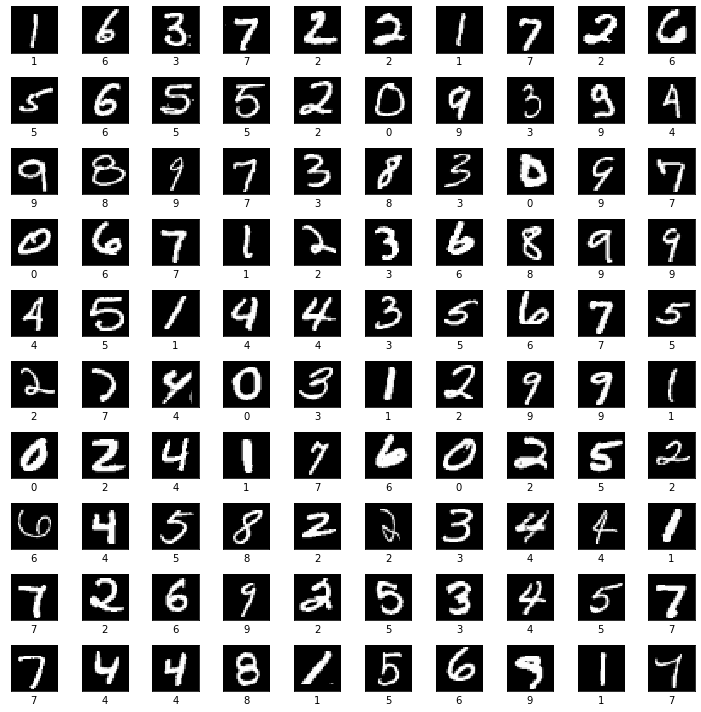

In [ ]:
# Visualize 10 examples of 10 classes. You can extend the following code:
rows, cols = 10, 10
#fig,ax = plt.subplots(nrows = rows, ncols = cols)

# ------- Your Code -------
plt.figure(figsize=(10,10))
for i in range(100):
    plt.subplot(rows, cols, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    pixels = x_trainval[i].reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.xlabel(y_trainval[i])


plt.tight_layout()
plt.savefig('fig1.pdf')   # Save the figures
#plt.show()   # These should be some visualization of data at the end of this section

# You can see an output example in the follow:

# 2. Digit classifiers

In this section, you'll begin developing models to perform digit classification.

Each model needs to be structured like so:
  1. Give a brief reason which model you are going to train and why you choose it
  1. Define hyper-parameters for model and optimization procedure
  1. Define your model
  1. Define optimization method and fit model to data
  1. Summarize your findings







## 2.1: Model [M1]: *fill-this-in* (25 points)

**Short description **: 
The intuition behind selection of SVM for MNIST digit classification is as follows -
Their dependence on relatively few support vectors means that they are 

1. They depend on few support vectors and make good compact models.
2. Training takes some time but after training is completed , the testing phase is fast.
3. They can also work with high dimensional data like MNIST n_classes =10 , also in cases where the number of samples is less than the number of features/dimensions.
4. They also have powerful kernel methods which can fit to various types of data.



### 2.1.1: Hyper-parameters

Define hyper-parameters for your model here

C and gamma are one of the two hyperparameters governing SVM.

**C**

---

*   The  c  argument specifies the cost of a violation to the margin. When the  c  argument is small, then the margins will be wider and many support vectors will be on the margin or will violate the margin. 
*   When the  c  argument is large, then the margins will be narrow and 
there will be few support vectors on the margin or violating the margin.

**gamma**

---

In order to fit an SVM using a non-linear kernel, we use the  SVC()  function.  To fit an SVM with a radial kernel we use  kernel="rbf".
It defines how far influences the calculation of plausible line of separation. When gamma is higher, nearby points will have high influence.
When low gamma means far away points also be considered to get the decision boundary.

In [ ]:
# ------- Your Code -------
C = [0.01,0.1,1,10]
Gamma = [0.01,0.1,1,10]
kernel = 'rbf'
param_grid = {'C': [0.01,0.1,1,10], 'gamma': [0.01,0.1,1,10], 'kernel': ['rbf']}

### 2.1.2: Data Preprocessing


In [ ]:
#
#
# ------- Your Code -------
#
# e.g. normalize, flatten input data.

# PCA
pca = PCA(0.95)
pca.fit(x_trainval)

x_trainval_red = pca.transform(x_trainval)
x_test_red = pca.transform(x_test)

print("Reduced:",x_trainval_red.shape)
print("Reduced:",x_test_red.shape)

In [ ]:


test_set = 'test'  #  or 'test'
# Decide all your hyperparameters based on validation performance
# Then, switch to 'test' for final evaluation


# Train_eval = 56,000 examples
# train:val = 3:1


if test_set == 'val':
    x_train_svm, x_eval_svm, y_train_svm, y_eval_svm = train_test_split(x_trainval_red, y_trainval, 
                                                        test_size=0.25, 
                                                        random_state=42)
    print('x_train.shape = {},  y_train.shape = {}'.format(x_train_svm.shape, y_train_svm.shape))
    print('x_eval.shape = {},  y_eval.shape = {}'.format(x_eval_svm.shape, y_eval_svm.shape))
    #train_idxs, val_idxs = ..., ...   # Fill in
    #x_train, y_train = x_trainval[train_idxs], y_trainval[train_idxs]
    #x_eval, y_eval = x_trainval[val_idxs], y_trainval[val_idxs]
else:
    x_train, y_train = x_trainval_red, y_trainval
    x_eval_svt, y_eval_svt = x_test_red, y_test


Reduced: (56000, 154)
Reduced: (14000, 154)


### 2.1.3: Model

Define your model here

In [ ]:
# ------- Your Code -------
svm = SVC()
gs = GridSearchCV(svm, param_grid, verbose=2, cv=2, refit=True, return_train_score=True, scoring="accuracy")




### 2.1.4: Fit Model

Define optimization procedure and fit your model to the data

In [ ]:
# ------- Your Code -------
gs.fit(x_train_svm,y_train_svm)

#  Please save the trained model
joblib.dump(gs, 'svm.pkl')

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] C=0.01, gamma=0.01, kernel=rbf ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... C=0.01, gamma=0.01, kernel=rbf, total= 4.4min
[CV] C=0.01, gamma=0.01, kernel=rbf ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.3min remaining:    0.0s


[CV] ................... C=0.01, gamma=0.01, kernel=rbf, total= 4.4min
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV] .................... C=0.01, gamma=0.1, kernel=rbf, total= 6.1min
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV] .................... C=0.01, gamma=0.1, kernel=rbf, total= 5.8min
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV] ...................... C=0.01, gamma=1, kernel=rbf, total= 5.9min
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV] ...................... C=0.01, gamma=1, kernel=rbf, total= 5.9min
[CV] C=0.01, gamma=10, kernel=rbf ....................................
[CV] ..................... C=0.01, gamma=10, kernel=rbf, total= 5.9min
[CV] C=0.01, gamma=10, kernel=rbf ....................................
[CV] ..................... C=0.01, gamma=10, kernel=rbf, total= 5.9min
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 210.1min finished


['svm.pkl']

In [ ]:
print(gs.best_estimator_)
#print(gs.cv_results_)
scores = gs.cv_results_["mean_test_score"].reshape(len(C), len(Gamma))
print(scores)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
[[0.87419048 0.19266667 0.11038095 0.11038095]
 [0.93930952 0.60702381 0.11038095 0.11038095]
 [0.9657381  0.94652381 0.18447619 0.11038095]
 [0.97571429 0.94888095 0.19211905 0.11038095]]


In [ ]:
#load your model for further usage
sav_svm = joblib.load("svm.pkl")
print(sav_svm.best_estimator_)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


### 2.1.5: Evaluation

Evaluate your model.
  * Evaluate models with different parameters 
  * Plot the score (accuracy) for each model using "plot_scores" function
  * Report score for the best model
  * Use "vis_predictions" function to visualize few examples of test/validation set with the corresponding predictions


In [ ]:
# ------- Your Code -------
# Example: y_pred = model.predict(x)
y_pred = sav_svm.predict(x_eval_svt)

GridSearchCV(cv=2, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 10], 'gamma': [0.01, 0.1, 1, 10],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=2)


NameError: ignored

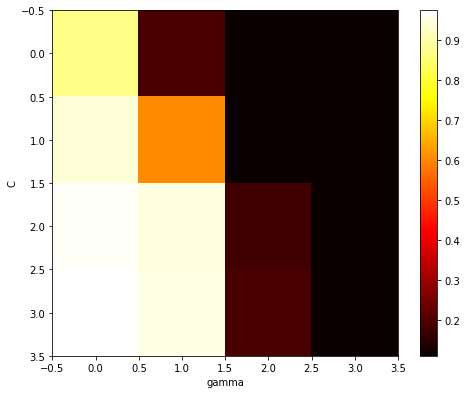

In [ ]:
# Here plot score (accuracy) for each model. You can use "plot_scores" function.

# Example: plot_scores(parameters, scores, "title", "x_label", "y_label"), 

# You can see an example in the follow.
# Note that the visualizations/plots provided are just simple examples/illustrations. 
# We encourage more informative and alternate methods to present results.

# DOES NOT PLOT XXXXXXXXXXXXXXXXXXXXXXX
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)


plt.figure(figsize=(8, 6))
xx_, yy_ = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
for (k, (C, gamma, clf)) in enumerate(classifiers):
    # evaluate decision function in a grid
    Z = clf.decision_function(np.c_[xx_.ravel(), yy_.ravel()])
    Z = Z.reshape(xx.shape)

    # visualize decision function for these parameters
    plt.subplot(len(C_2d_range), len(gamma_2d_range), k + 1)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)), size="medium")

    # visualize parameter's effect on decision function
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_2d, cmap=plt.cm.RdBu_r, edgecolors="k")
    plt.xticks(())
    plt.yticks(())
    plt.axis("tight")

Test accuracy: 98.14
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1445
           1       0.99      0.99      0.99      1641
           2       0.98      0.98      0.98      1345
           3       0.98      0.97      0.98      1407
           4       0.98      0.97      0.98      1380
           5       0.98      0.98      0.98      1273
           6       0.98      0.99      0.99      1414
           7       0.99      0.97      0.98      1449
           8       0.98      0.98      0.98      1321
           9       0.97      0.98      0.97      1325

    accuracy                           0.98     14000
   macro avg       0.98      0.98      0.98     14000
weighted avg       0.98      0.98      0.98     14000

Confusion Matrix:
 [[1435    0    1    0    1    2    3    0    2    1]
 [   0 1630    3    1    1    1    1    3    0    1]
 [   4    2 1322    4    1    0    1    4    6    1]
 [   0    2   14 1

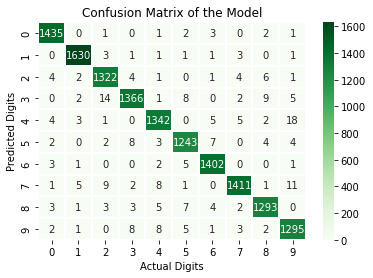

In [ ]:
# Here report the score for the best model
#
# ------- Your Code -------
#

display_classification_results(y_eval_svt, y_pred)
display_confusion_matrix(y_eval_svt, y_pred)

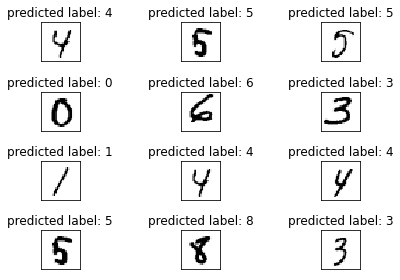

In [ ]:
# Visualize the predictions
# Example: vis_predictions(x_eval, y_pred, size_of_data)
#
#
# ------- Your Code -------
#
vis_predictions(x_test, y_pred, 25)

### 2.1.6: Summary

Summarize your findings:
 * Which hyper-parameters were important and how did they influence your results?
C and Gamma and kernel types are important in influencing our accuracy scores. Kernel with the **rbf** worked the best in our case with a test accuracy of 98% and training accuracy of 97% with a value of **C = 10** and **gamma = 0.01**.
Grid search is commonly used as an approach to hyper-parameter tuning that will methodically builds and evaluates model for each combination of parameters specified in a grid.


 * What were other design choices you faced?
 
1.   Training with SVM took lot of time, so we had to do data pre processing like Normalizing and applying PCA with variance of 0.95 on the original training dataset to reduce the number of dimensions from 784 to 134. It did not affect the accuracy nor reduced the precision after applying PCA.
2.  C has to be chosen carefully with cross-validation which is again computationally expensive with large datasets.


 
 * Any other interesting insights...
 Simple, efficient, faster and not many parameters to tune finely.

# 2.2: Model [M2]: *fill-this-in* (25 points)




### 2.2.1: Hyper-parameters

Define hyper-parameters for your method here

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)




### 2.2.2: Data Preprocessing


In [ ]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders


{'test': <torch.utils.data.dataloader.DataLoader at 0x7fcad80ec310>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7fcad80ec090>}

### 2.2.3: Model

Define your model here (all hyper-parameters in 2.1.1)

In [ ]:
#
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x

### 2.2.4: Fit Model


In [ ]:
from torch import optim

cnn = CNN()
print(cnn)
loss_func = nn.CrossEntropyLoss()   
loss_func
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

from torch.autograd import Variable
num_epochs = 10
train_loss = []
def train(num_epochs, cnn, loaders):
    
    cnn.train()
    total_train_loss =0  
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            total_train_loss += loss.item()
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
            pass
        total_train_loss = total_train_loss / (i + 1)
        train_loss.append(total_train_loss)
        pass
    
    
    pass
train(num_epochs, cnn, loaders)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
Epoch [1/10], Step [100/600], Loss: 0.1378
Epoch [1/10], Step [200/600], Loss: 0.0703
Epoch [1/10], Step [300/600], Loss: 0.0922
Epoch [1/10], Step [400/600], Loss: 0.0654
Epoch [1/10], Step [500/600], Loss: 0.0431
Epoch [1/10], Step [600/600], Loss: 0.0309
Epoch [2/10], Step [100/600], Loss: 0.1585
Epoch [2/10], Step [200/600], Loss: 0.0211
Epoch [2/10], Step [300/600], Loss: 0.1447
Epoch [2/10], Step [400/600], Loss: 0.0886
Epoch [2/10], Step [500/600], Loss: 0.0194
Epoch [2/10], Step [600/600], Loss: 0.0091
Epoch [3/10]

### 2.2.5: Evaluation

Evaluate your model.
  * Evaluate models with different parameters 
  * Plot score (accuracy) for each model using "plot_scores" function
  * Report the score for the best model
  * Use "vis_predictions" function to visualize few examples of test/validation set with the corresponding predictions


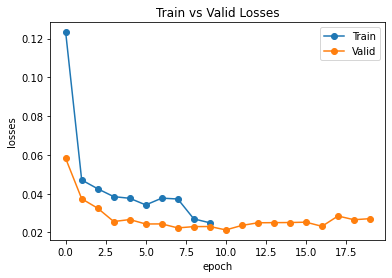

NameError: ignored

In [ ]:
#plot loss
plt.plot(train_loss,'-o')
plt.plot(val_loss,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')
 
plt.show()



In [ ]:
test_loss = list()
val_acc = list()
def test():
    # Test the model
    cnn.eval()
    total_test_loss=0
    for epoch in range(num_epochs):
        with torch.no_grad():
            correct = 0
            total = 0
            for i,(images, labels) in enumerate(loaders['test']):
                test_output, last_layer = cnn(images)
                pred_y = torch.max(test_output, 1)[1].data.squeeze()

                loss = loss_func(test_output, pred_y)
                total_test_loss += loss.item()

                accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
                pass
            print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
        total_test_loss = total_test_loss / (itr + 1)
        test_loss.append(total_test_loss)
        pass
    pass
test()

Test Accuracy of the model on the 10000 test images: 1.00
Test Accuracy of the model on the 10000 test images: 0.96
Test Accuracy of the model on the 10000 test images: 0.98
Test Accuracy of the model on the 10000 test images: 1.00
Test Accuracy of the model on the 10000 test images: 1.00
Test Accuracy of the model on the 10000 test images: 0.98
Test Accuracy of the model on the 10000 test images: 0.98
Test Accuracy of the model on the 10000 test images: 1.00
Test Accuracy of the model on the 10000 test images: 1.00
Test Accuracy of the model on the 10000 test images: 0.99


In [ ]:
# Visualize the predictions
# Example: vis_predictions(x_eval, y_pred, size_of_data)
#
#
# ------- Your Code -------
#

### 2.2.6: Summary
A Convolutional Neural Network is a type of neural network which is mainly used for image processing applications.We use CNN on MNIST dataset as we can get 99.06% accouracy. 

This model has 2 fully connected layers, ReLU activation function and max-pooling.Parameters used in this model are: in_channel is number of channels in input image, out_channe is number of chnnels in output image, size of convolving kernel is kernal_size, stride of convolution is 1 and padding is 2. forward _pass() defines the way we compute the output given these layers and functions.

Summarize your findings:
 * Which hyper-parameters were important and how did they influence your results?
 Hyperparameters used were Learning rate, batch_size and number of epochs.
LR is uaually a small number and have to be considered carefully, a high LR may never converge and
small LR will slow down the learning. Number of epochs is important to avoid overfitting.
Hyperparameters used are lerning rate which defines how quickly network updates the parameters.
Learning rate it set to be 0.001
Number of epoches which we set as 20. 
It is th enumber of times the whole training datais shown to the network while training.
Batch size is number of sub-samples given to the networkafter which paramenter will update.
we have set batch size to be 100

 * What were other design choices you faced?
 optimization method used is Adam.its an extenstion of SGD and RmsProp. it is one of the best optimizer
amnong adaptive optimizers and is widely used. Then we train the model using Cross Entropy Loss 
loss function. Here we calucate the loss function and backpropagate to update the weights.we have used validation function to caluate the accurcy.

 * Any other interesting insights
 The training loss for the model founf to be 0.1634 and the accuracy is found to be 99.06%

# 2.3: Model [M3] (Neural Networks): *fill-this-in* (25 points)
Intuition behind a simple CNN on MNIST dataset :
 

*   CNN uses multilayer perceptrons to do computation.
*   It requires little pre-processing compared to other image classification algorithms. 
*   The network can learn through filters on its own rather than manually engineering traditional algorithms. So, for the image classification tasks CNNs are the best-suited option.






### 2.3.1: Hyper-parameters

Define hyper-parameters for your method here

Hyper parameters are: 
We chose batch size of 64 for the train set, batch size of 32 for validataion and test set. Batch size is a hyperparameter that defines 
the number of samples the model looks at before updating the internal model parameter. This is mini batch gradient descent as the model 
works on small batches of data to calculate gradients and modifies the model parameters based off them.


1.   batch_size_train = 64
2.   batch_size_val = 32
3.   batch_size_test = 32
4.   no_epochs = 25
5.   learning_rate = 0.001
6.   dropout_prob = 0.5

We used Cross Entropy loss and Adam as our optimizer

In [121]:
# print(train_data.data.size())
# ------- Your Code -------
#
#
batch_size_train = 64
batch_size_val = 32
batch_size_test = 32
no_epochs = 20
learning_rate = 0.001
dropout_prob = 0.5


# You don't need the following code, if you can use data from 2.1.1.
# You can also use torch built-in functions (torch.utils.data)



### 2.3.2: Data Preprocessing


In [122]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=False, transform=transforms.Compose([transforms.ToTensor()]))
mnist_testset = datasets.MNIST(root='./data', train=False, download=False, transform=transforms.Compose([transforms.ToTensor()]))

mnist_valset, mnist_testset = torch.utils.data.random_split(mnist_testset, [int(0.9 * len(mnist_testset)), int(0.1 * len(mnist_testset))])



train_dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size_train, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_valset, batch_size=batch_size_val, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(mnist_testset, batch_size=batch_size_test, shuffle=False)



### 2.3.3: Model

Define your model here

In [123]:
class CNN_Model(torch.nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = torch.nn.Linear(7 * 7 * 64, 128)
        self.linear_2 = torch.nn.Linear(128, 10)
        self.dropout = torch.nn.Dropout(dropout_prob)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)

        x = self.conv_2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)

        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        y_pred = self.linear_2(x)
        return y_pred 
model = CNN_Model() 
print(model)      

CNN_Model(
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_1): Linear(in_features=3136, out_features=128, bias=True)
  (linear_2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)


In [124]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

### 2.2.4: Fit Model



Epoch: 1/20, Train Loss: 0.26678754, Val Loss: 0.05820886, Val Accuracy: 0.98100000
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.05820886

Epoch: 2/20, Train Loss: 0.09456801, Val Loss: 0.03740114, Val Accuracy: 0.98822222
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.03740114

Epoch: 3/20, Train Loss: 0.07460322, Val Loss: 0.03251990, Val Accuracy: 0.98811111
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.03251990

Epoch: 4/20, Train Loss: 0.06124362, Val Loss: 0.02565572, Val Accuracy: 0.99088889
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.02565572

Epoch: 5/20, Train Loss: 0.05188759, Val Loss: 0.02667388, Val Accuracy: 0.99111111

Epoch: 6/20, Train Loss: 0.04302232, Val Loss: 0.02438886, Val Accuracy: 0.99133333
Saving the model state dictionary for Epoch: 6 with Validation loss: 0.02438886

Epoch: 7/20, Train Loss: 0.03766435, Val Loss: 0.02443353, Val Accuracy: 0.99211111

Epoc

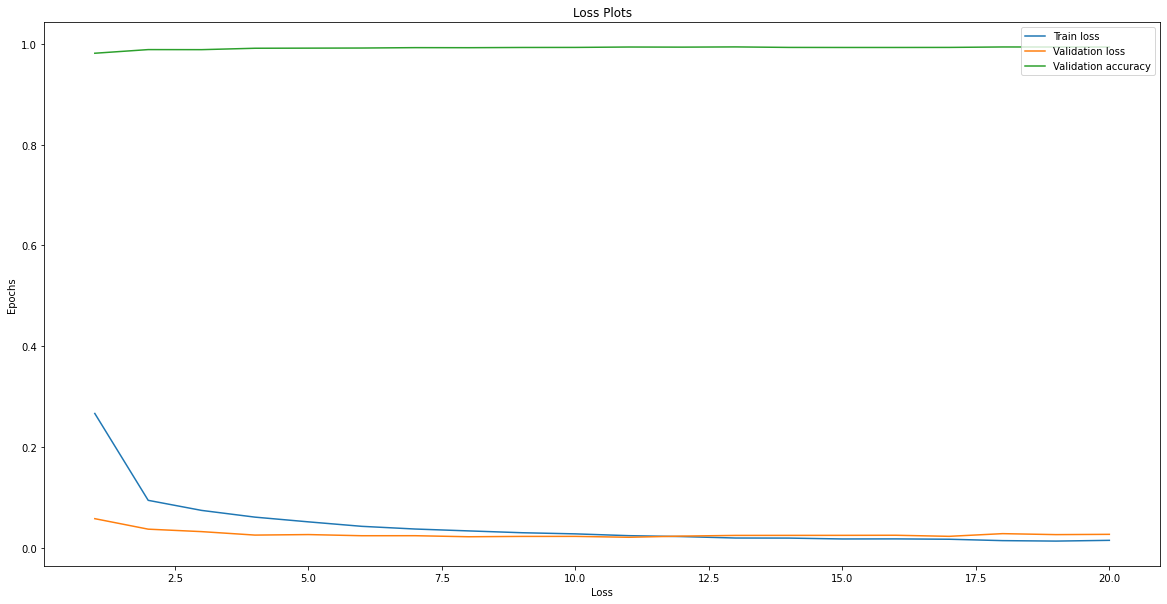

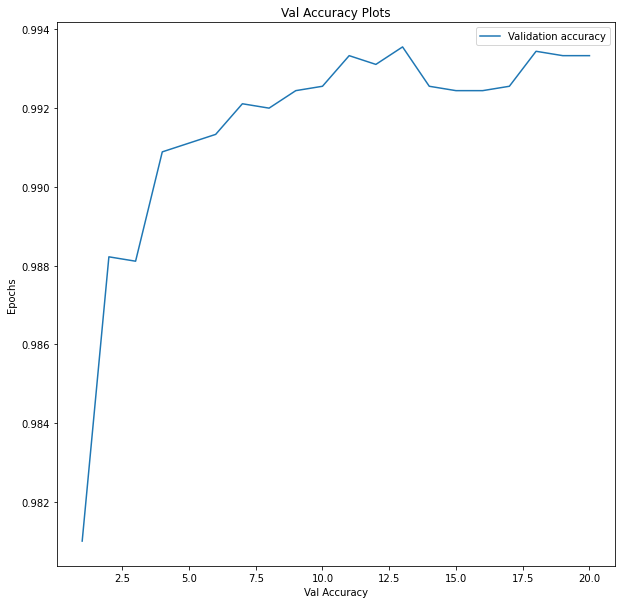

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
train_loss = list()
val_loss = list()
val_accuracy = list()
best_val_loss = 1
for epoch in range(no_epochs):
  
    total_train_loss = 0
    total_val_loss = 0

    model.train()
    # training
    for itr, (image, label) in enumerate(train_dataloader):
        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (itr + 1)
    train_loss.append(total_train_loss)
    
    # validation
    model.eval()
    total = 0
    for itr, (image, label) in enumerate(val_dataloader):
        pred = model(image)

        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1


    accuracy = total / len(mnist_valset)

    total_val_loss = total_val_loss / (itr + 1)
    val_loss.append(total_val_loss)
    val_accuracy.append(accuracy)
    print('\nEpoch: {}/{}, Train Loss: {:.8f}, Val Loss: {:.8f}, Val Accuracy: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_val_loss, accuracy))

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        print("Saving the model state Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, total_val_loss))
# Save your model using torch.save()
        torch.save(model.state_dict(), "model.dth")


### 2.2.5: Evaluation

Evaluate your model.

  * Loss curves: Plot epoch (# passes over training data) and loss
  * Accuracy curves: Plot epoch and accuracy over val/test set
  * Final numbers: Report final accuracy numbers for your model

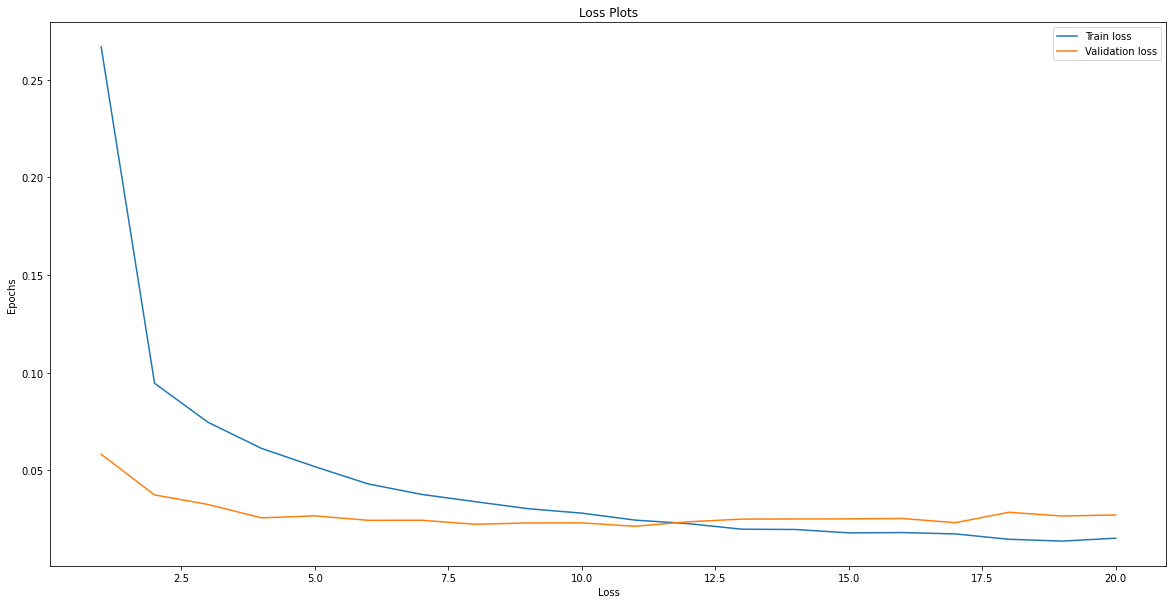

In [ ]:
# Here plot epoch (# passes over training data) and loss
#
# ------- Your Code -------
fig=plt.figure(figsize=(20, 10))
plt.plot(np.arange(1, no_epochs+1), train_loss, label="Train loss")
plt.plot(np.arange(1, no_epochs+1), val_loss, label="Validation loss")
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.savefig('losses.png')



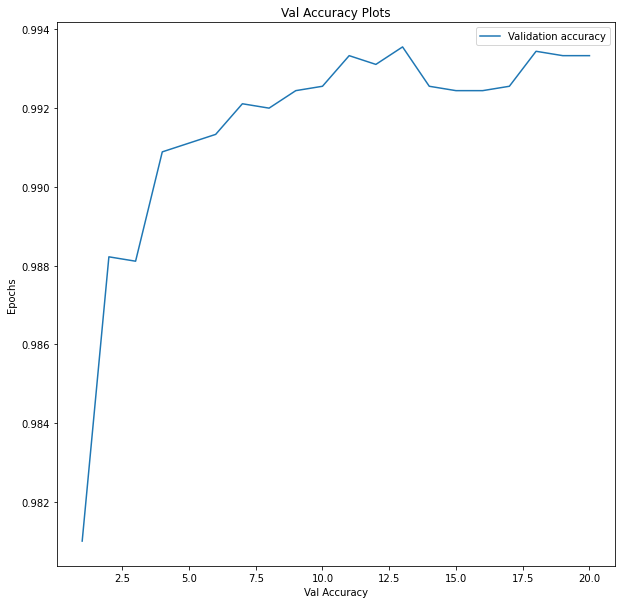

In [ ]:
# Here plot epoch and accuracy over val/test set
#
# ------- Your Code -------
#
fig2=plt.figure(figsize=(10, 10))
plt.plot(np.arange(1, no_epochs+1), val_accuracy, label="Validation accuracy")
plt.xlabel('Val Accuracy')
plt.ylabel('Epochs')
plt.title("Val Accuracy Plots")
plt.legend(loc='upper right')
# plt.show()
plt.savefig('val_accuracy.png')

In [128]:
# Example:
# net = Net()
# net.load_state_dict(torch.load("PATH"))
# test model
model.load_state_dict(torch.load("model.dth"))
model.eval()

CNN_Model(
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_1): Linear(in_features=3136, out_features=128, bias=True)
  (linear_2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

In [129]:
# Here report the score for the best model
#
# ------- Your Code -------
# Print model's state_dict
print("Model's state_dict parameters:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict parameter:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict parameters:
conv_1.weight 	 torch.Size([32, 1, 3, 3])
conv_1.bias 	 torch.Size([32])
conv_2.weight 	 torch.Size([64, 32, 3, 3])
conv_2.bias 	 torch.Size([64])
linear_1.weight 	 torch.Size([128, 3136])
linear_1.bias 	 torch.Size([128])
linear_2.weight 	 torch.Size([10, 128])
linear_2.bias 	 torch.Size([10])
Optimizer's state_dict parameter:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7]}]


In [ ]:
# ------- Your Code -------
# Example:
# net = Net()
# net.load_state_dict(torch.load("PATH"))
# test model


results = list()
correct = 0
for itr, (image, label) in enumerate(test_dataloader):
    pred = model(image)
    pred = torch.nn.functional.softmax(pred, dim=1)
    #img = Variable(img)
    for i, p in enumerate(pred):
        if label[i] == torch.max(p.data, 0)[1]:
          total = total + 1
          results.append((image, torch.max(p.data, 0)[1]))

test_accuracy = correct / (itr + 1)
print('Test accuracy {:.8f}'.format(test_accuracy))




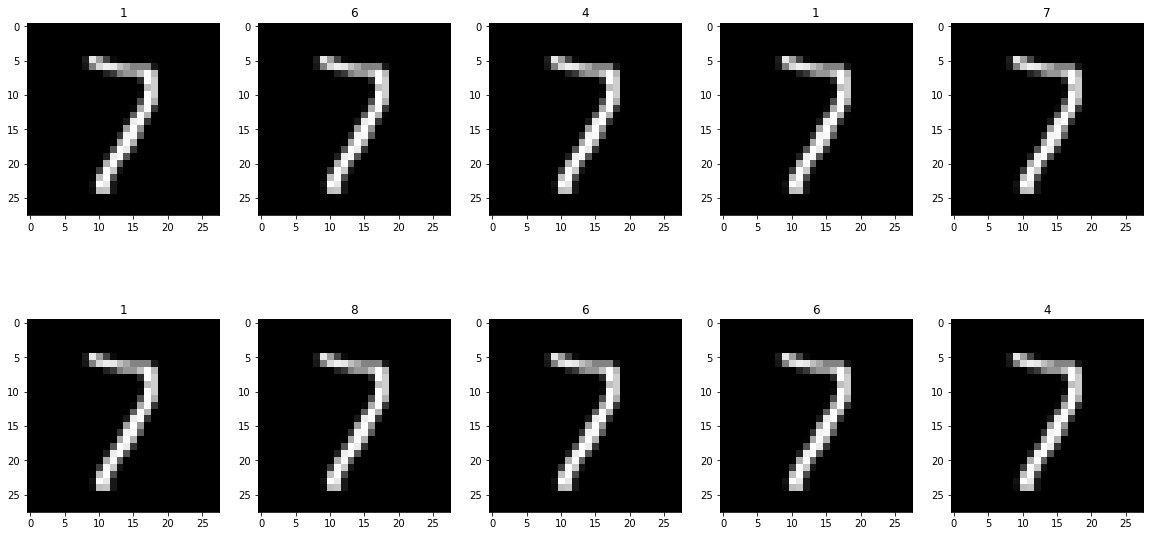

In [130]:
# Visualize the predictions
# Example: vis_predictions(x_eval, y_pred, size_of_data)
#
# ------- Your Code -------
# visualize data
fig3=plt.figure(figsize=(20, 10))
for i in range(1, 11):
  fig3.add_subplot(2, 5, i)
  img = results[i][0].numpy()[0]
  img = np.transpose(img, (1,2,0))
  #show the image
  plt.imshow(np.squeeze(img), cmap = 'gray')
  plt.title(results[i][1].item())
plt.show()


### 2.3.6: Summary

Summarize your findings:
 * Which hyper-parameters were important and how did they influence your results?


1.   Activation function - Used ReLu as it is less computationally expensive than tanh and mathematically simplers. 
2.  learning rate of 0.001 
3. Filter size of 3*3 is used in the model as smaller filters collect as much local information as possible, bigger filters represent more global information. 
4. Layers of format Conv-Pool-Conv-Pool (2x) times was followed with channel increasing from 32–64–128.
5. Dropout was also intrduced to avoid over-fitting

 * What were other design choices you faced?
2-D covolution Neural Network for MNIST digit recognition.
Architecture : 2 convolution layer followed by pooling layer, a fully connected layer, and softmax layer respctively.
**Hyperparamter:**
num_epochs = 10
batch_size = 100

We chose batch size of 100 each for the train set and test set.


We have the possibility to use different learning rates  and also increase the epochs, but for MNIST dataset 25 epochs were suffiecient and further iterations did not yield any better results.

Training was relatively faster in CNN models. For bigger datasets, gpu can be used to accelerate parallel computation.

We can also use various optimizers to see the change in accuracy but we preferred to use classic ADAM.
 * Any other interesting insights?
 For 10 epochs we achieved **training loss of 0.1634 **and test accuracy of 99 percent. 

# 3. Summary (20 points)

Enter your final summary here.

You should now compare performance  on the three models [M1], [M2] and [M3]. Present this in a tabular format and/or using plots.

Which model do you recommend to perform digit classification and why?

Feel free to discuss other insightful observations.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


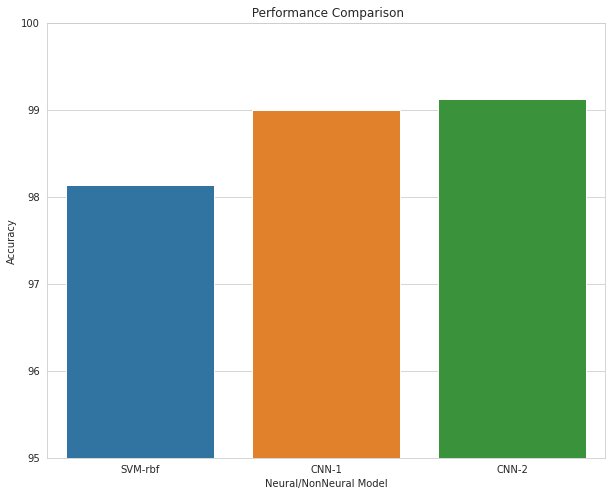

In [132]:
sns.set_style('whitegrid')
ax = sns.barplot(['SVM-rbf','CNN-1','CNN-2'],[98.14,99.00,99.13]);
ax.set(title=" Performance Comparison", xlabel="Neural/NonNeural Model", ylabel="Accuracy",ylim=(95,100));

1. Model 2.3 M3 performed the best with just simple CONV-RELU(2x) layers. Especially the training accuracy was almost 99%. However, the testing initially showed good results with the saved model model.dth, which later we lost due to which we could see significant dip in test performance. 

2. Model 2.2 M2 performed best  in performance compared to M3 and has an equall precision over train, val and test dataset.

3. SVM with lesser hyperparameter tuning intensive is also a good choice for this dataset and almost acheived 98 % test accuracy and is our preferable model in this case.ALthough training train was bit more, we could reduce the time effectively by applying PCA and then rbf kernel on the data.
